# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs)

## Problem 0 (45 points)

In this problem, you'll implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [1]:
from scipy.integrate import solve_ivp
from euler import ForwardEuler
import numpy as np
import matplotlib.pyplot as plt

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

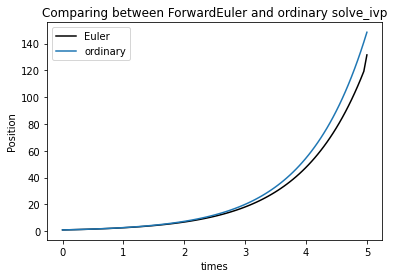

In [27]:
y0 = 1

v0 = np.array([y0, y0])   # there is a bug in my Euler.py, so I use specical input
f = lambda t, y : np.array([y[0], y[0]])
t_span = (0, 5)
t_eval = np.linspace(0, 5, 100)

v00 = np.array([y0])   # input for ivp_solve
f1 = f = lambda t, y : np.array([y[0]])


sol = solve_ivp(f, t_span, v0,method=ForwardEuler, t_eval=t_eval, h=0.01)
sol1 = solve_ivp(f1, t_span, v00, t_eval=t_eval)


plt.plot(sol.t, sol.y[0], c='k', label='Euler')
plt.plot(sol.t, sol1.y[0], label='ordinary')
plt.title("Comparing between ForwardEuler and ordinary solve_ivp")
plt.ylabel("Position")
plt.xlabel("times")
plt.legend()
plt.show()

In [7]:
import sympy as sym
from sympy.solvers import ode

a, t = sym.symbols('a t') # symbol
y = sym.Function('y') # symbolic function
eqn = y(t).diff(t) - y(t) # eqn = 0
eqn

-y(t) + Derivative(y(t), t)

In [8]:
ode.classify_ode(eqn)

('separable',
 '1st_exact',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_homogeneous',
 'separable_Integral',
 '1st_exact_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral')

In [25]:
f=ode.dsolve(eqn, hint='separable', ics={y(0): 1}) # we solve the differential equation using the hinted method
print(f)

Eq(y(t), exp(t))


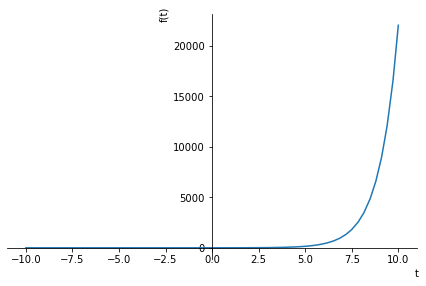

In [22]:
sym.plot(f.rhs)

In [29]:
f_real = np.exp(sol1.t) # exact solution
error1 = abs(f_real-sol.y) # errors in the methods
error2 = abs(f_real-sol1.y)
print('The largest error for the Forward Euler method is:{}'.format(np.amax(error1)))
print('The largest error for the default ivp_solve method is:{}'.format(np.amax(error2)))

The largest error for the Forward Euler method is:21.82816411588145
The largest error for the default ivp_solve method is:0.05859827545307894


### Part C (15 points)

Implement unit tests that verify that ODE solutions (numerically) obey the ODE.  Try this for $y'(t) = y$, with $y(0) = 1$ on the domain $t\in [0,5]$.  use a finite difference stencil with step size `k` (`k` should be smaller than the `h` you used to solve the ODE) to compute the derivative at several points.  You should only expect the derivative to be accurate to about `h*y`

Implement tests for `solve_ivp` using the default settings as well as using your `ForwardEuler` implementation.

Put these tests in [`test.py`](test.py).  Set up your unit tests to run when you push changes to GitHub using GitHub actions. In order to respect server time, set a 10 minute time-limit on your github actions workflow. To see an example of how to set a time-limit, see line 9 in the relevant file from Homework 3 by clicking [here](https://github.com/caam37830-2021/homework-3-template/blob/main/.github/workflows/push.yml).

---

*put any discussion here*

## Problem 1 (20 points)

In this problem, you'll solve two simple, but related, ODEs using `solve_ivp`.

### Part A (13 points)

On the surface of the earth, objects are accelerated by a more-or-less constant gravitational field.  We'll consider an object thrown vertically with initial position $y=y_0$, and initial velocity $y' = v_0$.

We'll consider a simplified problem with no wind resistance.  Newton's laws of motion tell us $y''(t) = -g$, where $g = 9.8 m/s^2$.  This is a second order ODE, which we can turn into a system of first order ODEs using the substituion $p = y'$.  Then we have
\begin{equation}
\begin{cases}
y'(t) = p(t)\\
p'(t) = -g
\end{cases}
\end{equation}

You can encode this using a vector $v$, where $v[0]$ is the value $y$ above, and $v[1]$ is $p$.

Use `solve_ivp` to solve for `y(t)` using `y0 = 0` and `y'(0) = 10` (i.e. you throw a ball straight up in the air at a speed of $10 m/s$).  Run this simulation for $4$ seconds.  make a plot of the trajectory $y$ as a function of $t$ (i.e. $t$ is on the horizontal axis and $y$ is on the vertical axis).  Set up an event to end the simulation when `y` is zero again (when the ball hits the ground).  At what time does the ball hit the ground?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

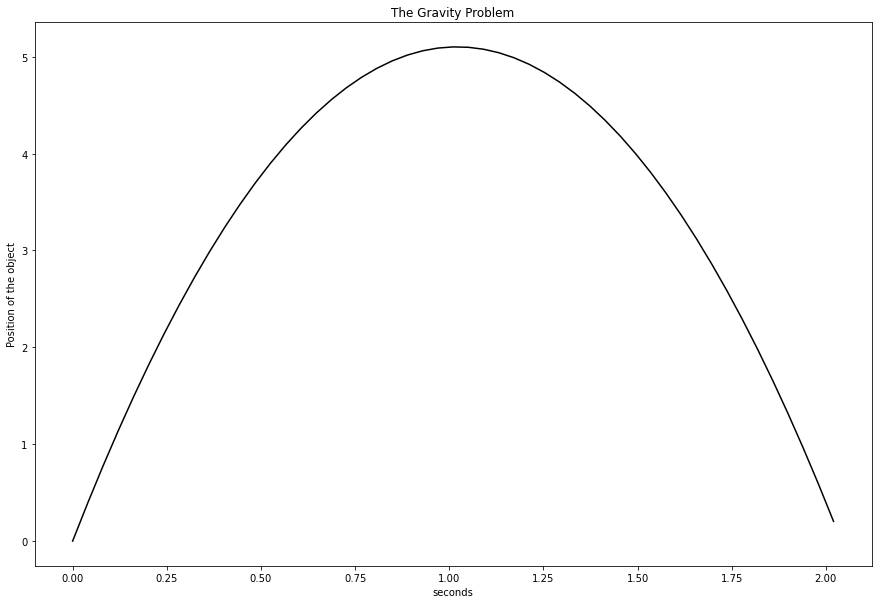


The object hits the ground again when t=2.040816326530612 and reaches the highest point when t=1.0204081632653061.


In [31]:
y0 = 1e-100
p0 = 10
g = 9.8


v0 = np.array([y0, p0])
f = lambda t, y : np.array([y[1], -g] )
t_span = (0, 4)
t_eval = np.linspace(0, 4, 100)

def Hitground(t, y):  # events for hitting the ground
    return y[0]

def Highest(t, y):  # events for the highest point
    return y[1]

Hitground.terminal=True


sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=[Hitground, Highest])

plt.plot(sol.t, sol.y[0], c='k')
plt.title("The Gravity Problem")
plt.ylabel("Position of the object")
plt.xlabel("seconds")
plt.show()
print("")
print("The object hits the ground again when t={} and reaches the highest point when t={}.".format(sol.t_events[0][0],sol.t_events[1][0]))

### Part B (7 points)

We'll now take into account wind resistance on the ball.  We'll make a bunch of assumptions, and simply assume that the drag can be expressed as a force that accelerates the ball by adding a term `y''(t) = p'(t) = -9.8 -0.02 sgn(p(t)) p(t)**2`, where `sgn(p(t))` can be computed using `np.sign` (the sign of the velocity).

Incorporate this term into the system of ODEs, and use `solve_ivp` to plot the trajectory of the ball with the same initial conditions as in part A.  Set up an event to terminate the simulation when the ball hits the ground.  At what time does the ball hit the ground?  Is this before or after the ball hits the ground when there is no wind resistance?

Set up an event to find when the ball is at its highest point (`p(t) = 0`).  This should not terminate the simulation.

---

*put any answers/discussion here*

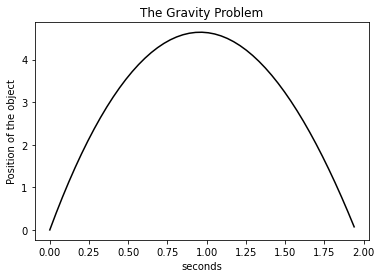


The object hits the ground again when t=1.9473629973330377 and reaches the highest point when t=0.9587340530673001.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

y0 = 1e-100
p0 = 10
g = 9.8
u = 0.02


v0 = np.array([y0, p0])
f = lambda t, y : np.array([y[1], -g-u*np.sign(y[1])*y[1]**2] )
t_span = (0, 4)
t_eval = np.linspace(0, 4, 100)

def Hitground(t, y):   # event for hitting the ground 
    return y[0]

def Highest(t, y):  # event for the highest position
    return y[1]

Hitground.terminal=True


sol = solve_ivp(f, t_span, v0, t_eval=t_eval, events=[Hitground, Highest])

plt.plot(sol.t, sol.y[0], c='k')
plt.title("The Gravity Problem")
plt.ylabel("Position of the object")
plt.xlabel("seconds")
plt.show()
print("")
print("The object hits the ground again when t={} and reaches the highest point when t={}.".format(sol.t_events[0][0],sol.t_events[1][0]))


# With wind resistence, the object hits the ground again before time for the case where wind resistence is not preseted.

## Problem 2 (25 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the trick from problem 1 to write this as 8 first order ODEs by introducing the vector-valued variables
$p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

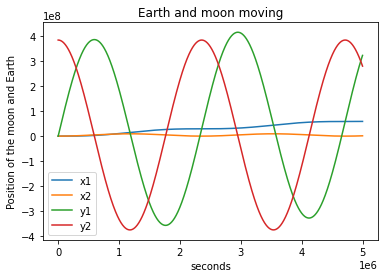

In [17]:
y0 = [0, 384.4*10**6]
x0 = [0, 0]
p0 = [0, 0]
q0 = [1.022*10**3, 0]
G = 6.67e-11
m1 = 5.972e24
m2 = 0.07346e24
r = 384.4e6
Fg = G*m1*m2/(r**2)

# y=[x1,x2,p1,p2,y1,y2,q1,q2]
v0 = np.array([x0[0], x0[1], p0[0], p0[1], y0[0], y0[1], q0[0], q0[1]])
f = lambda t, y : np.array([y[2], y[3], -Fg*(y[0]-y[4])/(m1*r), -Fg*(y[1]-y[5])/(m1*r),
                           y[6], y[7], Fg*(y[0]-y[4])/(m2*r), Fg*(y[1]-y[5])/(m2*r)] )
t_span = (0, 5e6)
t_eval = np.linspace(0, 5e6, 5000)


sol = solve_ivp(f, t_span, v0, t_eval=t_eval)

plt.plot(sol.t, sol.y[0], label='x1')
plt.plot(sol.t, sol.y[1], label='x2')
plt.plot(sol.t, sol.y[4], label='y1')
plt.plot(sol.t, sol.y[5], label='y2')
plt.legend()
plt.title("Earth and moon moving")
plt.ylabel("Position of the moon and Earth")
plt.xlabel("seconds")
plt.show()

### Part B (10 points)

The [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) is a simplified model of atmospheric convection, which is one of the earliest systems investigated which exhibit [chaotic behavior](https://en.wikipedia.org/wiki/Chaos_theory).

\begin{equation}
\begin{cases}
dx/dt = \sigma( y - x)\\
dy/dt = x( \rho - z) - y\\
dz/dt = xy - \beta z
\end{cases}
\end{equation}

$x$ is the rate of convection, and $y$ and $z$ measure horizontal and vertical temperature variation.

You can use the parameters Lorentz used: $\sigma=10, \beta = 8/3, \rho = 28$.  
Run one simulation starting $x = y = z = 10$.  Run the simulation for $t\in [0,7]$.

Run another simulation starting at $y = z = 10$, and $x = 10.1$.  Run the simulation for $t \in [0,7]$.

Plot both solution trajectories in the $x,y$ plane (i.e. `plt(sol.y[0], sol.y[1],...`) using different colors (include labels, a title, and legend).  This system is chaotic, so the trajectories should start close and then get further apart.

---

*put any answers/discussion here*

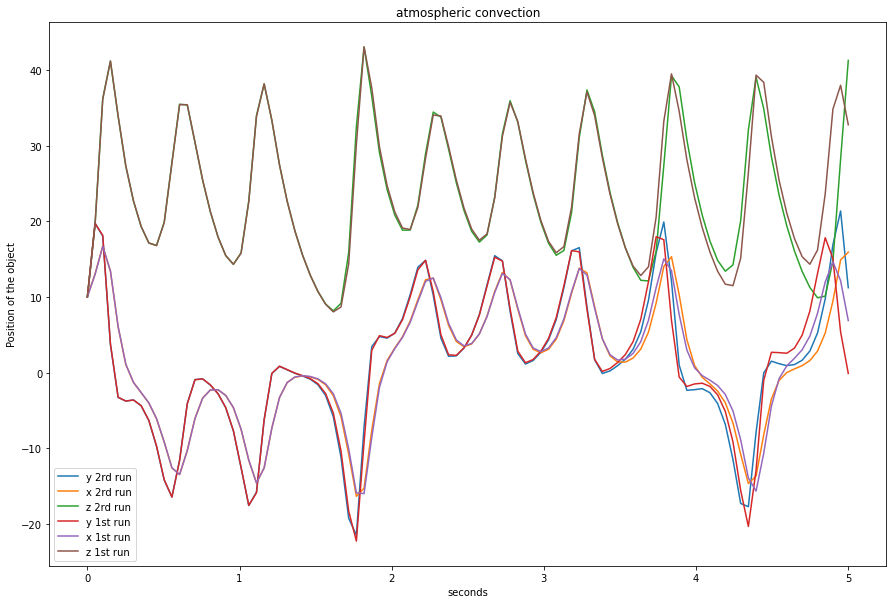

In [26]:
y0 = [10, 10]
x0 = [10, 10.1]
z0 = [10, 10]
sigma = 10
beta = 8/3
rho = 28

# y=[y, x, z]
v0 = np.array([[y0[0], x0[0], z0[0]], [y0[1], x0[1], z0[1]]])
f = lambda t, y : np.array([y[1]*(rho-y[2])-y[0], sigma*(y[0]-y[1]), y[1]*y[0]-beta*y[2]] )
t_span = (0, 7)
t_eval = np.linspace(0, 7, 100)


sol1 = solve_ivp(f, t_span, v0[0,:], t_eval=t_eval)  # two runs
sol2 = solve_ivp(f, t_span, v0[1,:], t_eval=t_eval)


plt.plot(sol.t, sol2.y[0], label='y in 2rd run')
plt.plot(sol.t, sol2.y[1], label='x in 2rd run')
plt.plot(sol.t, sol2.y[2], label='z in 2rd run')
plt.plot(sol.t, sol1.y[0], label='y in 1st run')
plt.plot(sol.t, sol1.y[1], label='x in 1st run')
plt.plot(sol.t, sol1.y[2], label='z in 1st run')
plt.title("atmospheric convection")
plt.ylabel("Position of the object")
plt.xlabel("seconds")
plt.legend()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

## Problem 3 (10 points)

Use functionality from `scipy.sparse` to help illustrate your answers to the following questions.

In the [class materials on differentiation](https://caam37830.github.io/book/04_functions/differentiation.html), we defined `forward_diff_matrix` and `backward_diff_matrix`.  What vectors characterize the nullspace of each of these matrices (i.e. vectors `x` so that `D @ x = 0`)?

Give an interpretation (from calculus) of the vector `y` where `y` solves the linear system `D @ y = x`, where `D` is a finite-difference matrix.  What is the implication of the nullspace of `D` on solving this linear system?

Create a finite difference operator for the Laplacian $\Delta = \partial_x^2 + \partial_y^2$ where second-order differences are based on the stencil `[1, -2, 1]`.  What is the nullspace of this matrix?

---

*Your answer here.  You can create some code cells as well*

In [4]:
# For forward_diff_matrix and any vector x=[x1 x2 ... xn]^t, Ax=0 implies that x2-x1=x3-x2=...=xn-x(n-1).
# In other word, any x\in R^n s.t. x1=x2=x3=x4=...=xn is in the nullspace of a forward matrix and therefore
# x=[1 1 1 1 ... 1]^t characterize the nullspace of a forward diff matrix.

# For backward_diff_matrix and any vector x=[x1 x2 ... xn]^t, Ax=0 implies that x2-x1=x3-x2=...=xn-x(n-1).
# In other word, any x\in R^n s.t. x1=x2=x3=x4=...=xn is in the nullspace of a backward matrix and therefore
# x=[1 1 1 1 ... 1]^t also characterize the nullspace of a backward diff matrix.

# D@y = x (if D is D1, which is D1=D/h) implies that y=f(t) is a function satisfies y_i = f'(ti) = x_i approximately
# for small enough h, where [t0 t1 ... tn] is a list of grid points.

# The solvability of the linear system depends on the dimension of nullspace
# of D. If dim ker(D)=0, then Dy=x has an unique solution for every x\in R^n.
# If dim ker(D)\=0, then Dy=x only can be solve for some of the x.



# Create a finite difference operator for Laplacian
import scipy.sparse as sparse

def forward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(n - 1):
        i.append(k)
        j.append(k)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

def backward_diff_matrix(n):
    data = []
    i = []
    j = []
    for k in range(1,n):
        i.append(k)
        j.append(k)
        data.append(1)

        i.append(k)
        j.append(k-1)
        data.append(-1)
        
    # we'll just set the last entry to 0 to have a square matrix
    return sparse.coo_matrix((data, (i,j)), shape=(n, n)).tocsr()

def Laplacian_operator(n):
    D = forward_diff_matrix(n) @ backward_diff_matrix(n)  # construct the second order matrix
    Dx = sparse.kron(sparse.eye(n), D).tocsr() # in x direction
    Dy = sparse.kron(D, sparse.eye(n)).tocsr() # in y direction
    L = sparse.kronsum(Dx, Dy)  # combining
    return L
    
D2 = Laplacian_operator(11)

print(D2[:15,:15].todense())  # see a slice of the Laplacian matrix
print(D2[-15:,-15:].todense())
# Since row sum is 0 for the Laplacian matrix, [x1, x2, ..., xn]\in R^n, where x1=x2=x3=...=x4, should be in the kernel
# of the matrix.

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -3.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -3.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -3.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -3.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -3.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -3.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -3.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -3.]]
[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.